# Modelado predicción de roya con redes LSTM



In [1]:
import sys
import os
sys.path.append("../../src")

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.python.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

# from eval import eval_model_one_hot
from metrics import f1, f1_loss
# from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from tensorflow.keras.utils import plot_model

from training import train, create_training_folder, create_callbacks, step_decay_exp
from tensorflow.python.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.python.keras.backend as K

import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras import Input
from tensorflow.python.keras.backend import concatenate
from tensorflow.python.keras.layers import Embedding,Masking, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, concatenate, Activation, SpatialDropout1D, Permute, Concatenate, GRU, MaxPooling1D, Flatten, Add, MaxPool1D
from tensorflow.python.keras.models import Sequential, Model
from tensorflow_addons.rnn import LayerNormLSTMCell
from tensorflow_addons.utils.types import Activation
from data import create_dataset

from training import train, create_training_folder
from data import load_ts_dataset

print("all libraries loaded!")


all libraries loaded!


Using TensorFlow backend.


In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # for the notebook tu run on CPU son GPU can be used for training in parallel
os.environ["CUDA_VISIBLE_DEVICES"] = ""


## Train test datasets

Before training the model, we first have to split data in different groups:
* Train: train the model.
* Test: measure the performance of the train modelo.

We use the StratifiedShuffleSplit to keep the same crop distrution among all the splits.

LSTM networks are stochastic models, so they depend on the initialization parametrs, random state, etc. To avoid over estimating the classifier performance, we should train the model on different splits evaluate the model on each split, so we can get the distribution of the model score and see the variability in its performance.
For simplicity, in this case just one split is used.


In [1]:
   
cols = ['temp_min', 'temp_mean', 'temp_max',
        'hum_min', 'hum_mean', 'hum_max', 
       'prec_min', 'prec_mean', 'prec_max', 
#        'dec_event_per', 
        'dec_event_per_skip',
        'prec_acum_60_porc',
       'dyear_sin', 'dyear_cos', 'altitud'] 

sequence_length = 15
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_ts_dataset(sequence_length,
                                                                    response_var="perc_detected", 
                                                                    cols =cols, 
                                                                     missing_values =True, fill_missing_with=-1
                                                                   )



print(X_train.shape)

# scaler = preprocessing.StandardScaler().fit(X_train)
# scaler = preprocessing.MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)



print(X_train.shape)


NameError: name 'load_ts_dataset' is not defined

In [5]:
y_test.describe()

count    20644.000000
mean        -0.826518
std          0.382442
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max          1.000000
Name: perc_detected, dtype: float64

## Model definition
We start creating a basic LSTM model with just one layer adn 64 units.
* The model has an initial Embedding layer responsible for creating the multidimensional representation of the crop codes. Each crop code is encoded in a vector of 20 dimensions. (This number has been chosen from experimentation.
* The second layer, LSTM will learn the patterns in the "sentences"
* The final dense layer will map the LSTM output to each output neuron, it has as many neurons as crop categories.




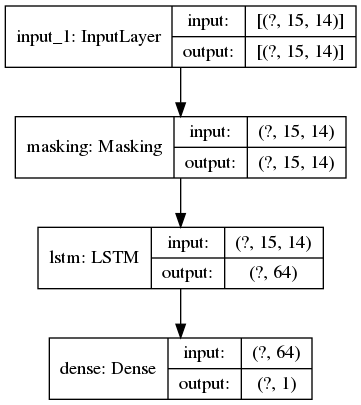

In [6]:

num_features= X_train.shape[2]

#[batch, timesteps, feature]
input = Input(shape=(sequence_length,num_features))

x = Masking(mask_value=-1.)(input)
x = LSTM(units=64)(x)
# x = Flatten()(x)
output = Dense(1, activation='relu')(x)
model = Model(input, output)

plot_model(model, show_shapes = True)



In [7]:
training_params = {
    'loss': "mse",
    'optimizer': tf.optimizers.RMSprop(lr=0.001),
    'metrics': ['mae', 'mse'],
#     'run_eagerly': False
}
model.compile(**training_params)




In [8]:
def train_evaluate_model(model, tag, X_train, y_train, X_test, y_test, callbacks = None, epochs=100, metric="mse"):
    K.clear_session()

    folder = create_training_folder("course", tag, add_timestamp=False)
    
    if callbacks is None:
        callbacks = []    
        callbacks.append(CSVLogger('{}/training_history.csv'.format(folder), append=True, separator=';'))
        stopper = keras.callbacks.EarlyStopping(monitor=metric,
            # "no longer improving" being defined as "no better than 1e-3 less"
            min_delta=0.0001,
            mode="min",
            # "no longer improving" being further defined as "for at least 8 epochs"
            patience=10, verbose=1)
        callbacks.append(stopper)
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='{}/training_history.csv'.format("model.checkpoint"),
            save_weights_only=True,
            monitor=metric,
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)


    model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks = callbacks)

    loss = model.evaluate(X_test, y_test, verbose=0)

    print("Loss on test data: {}".format(loss))
    return folder
    

In [9]:


folder = train_evaluate_model(model, "lstm_missing", X_train, y_train, X_test, y_test, epochs=200)
    

Epoch 1/200
1936/1936 - 17s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 2/200
1936/1936 - 14s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 3/200
1936/1936 - 15s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 4/200
1936/1936 - 17s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 5/200
1936/1936 - 15s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 6/200
1936/1936 - 14s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 7/200
1936/1936 - 15s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse: 0.8294
Epoch 8/200
1936/1936 - 18s - loss: 0.8296 - mae: 0.8300 - mse: 0.8296 - val_loss: 0.8294 - val_mae: 0.8299 - val_mse:

Best f1-score on test dataset: **0.7120**

In [10]:
BASE_FOLDER = "../../results/"

def plot_results(training_folder, metric = None):
    if not metric:
        metric = "f1"
    path = os.path.join(BASE_FOLDER, training_folder, "training_history.csv")
    df = pd.read_csv(path, sep=";")

    print("Results file: {}".format(training_folder))
    print("Last 10 records avg: ")
    print(df.tail(10).mean())

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    plt.title(training_folder)
    axs[0].plot(df["loss"], label='loss')
    axs[0].plot(df["val_loss"], label='val_loss')
    axs[0].legend(loc="upper right")
    axs[1].plot(df[metric], label=metric)
    axs[1].plot(df["val_"+metric], label='val_'+metric)
    axs[1].legend(loc="lower right")
    

In [11]:
plot_results("ann_v1", metric="mse")

Results file: ann_v1
Last 10 records avg: 
epoch       17.500000
loss         0.022235
mae          0.079574
mse          0.022235
val_loss     0.023177
val_mae      0.082842
val_mse      0.023177
dtype: float64


In [12]:

y_pred_val = model.predict(X_val)

print("MSE sobre el conjunto de validacion: {}".format(mean_squared_error(y_val, y_pred_val)))
print("MAE sobre el conjunto de validacion: {}".format(mean_absolute_error(y_val, y_pred_val)))

MSE sobre el conjunto de validacion: 0.839864137737962
MAE sobre el conjunto de validacion: 0.8403816722657708
